In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib as plt
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
%matplotlib inline

In [2]:
sales_url = "https://data-fairfaxcountygis.opendata.arcgis.com/datasets/Fairfaxcountygis::tax-administrations-real-estate-sales-data.csv?outSR=%7B%22latestWkid%22%3A2283%2C%22wkid%22%3A102746%7D"
dwellings_url = "https://data-fairfaxcountygis.opendata.arcgis.com/datasets/Fairfaxcountygis::tax-administrations-real-estate-dwelling-data.csv?outSR=%7B%22latestWkid%22%3A3857%2C%22wkid%22%3A102100%7D"
addresses_url = "https://data-fairfaxcountygis.opendata.arcgis.com/datasets/Fairfaxcountygis::tax-administrations-real-estate-legal-data.csv?outSR=%7B%22latestWkid%22%3A3857%2C%22wkid%22%3A102100%7D"
sales = pd.read_csv(sales_url)
dwellings = pd.read_csv(dwellings_url)
addresses = pd.read_csv(addresses_url)

/tmp/ipython-input-2031590121.py:4: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  sales = pd.read_csv(sales_url)


In [3]:
for col_name in dwellings.columns:
        print(col_name)

OBJECTID
PARID
STYLE_DESC
YRBLT
EFFYR
YRREMOD
RMBED
FIXBATH
FIXHALF
RECROMAREA
WBFP_PF
BSMTCAR
USER6
USER10
GRADE_DESC
SFLA
BSMT_DESC
CDU_DESC
EXTWALL_DESC
HEAT_DESC
USER13_DESC
USER7_DESC
USER9_DESC
CreationDate
Creator
EditDate
Editor


In [4]:
dwellings.drop(['EFFYR', 'RECROMAREA', 'WBFP_PF', 'BSMTCAR', 'CreationDate', 'Creator', 'EditDate', 'Editor', 'USER10', 'GRADE_DESC', 'USER9_DESC', 'USER7_DESC'], axis=1, inplace=True)
dwellings.rename(columns={
    'OBJECTID':'dwelling_id',
    'PARID': 'parcel_id',
    'STYLE_DESC': 'levels_style',
    'YRBLT': 'year_built',
    'YRREMOD': 'year_remodeled',
    'RMBED': 'bedrooms',
    'FIXBATH': 'baths',
    'FIXHALF': 'half_baths',
    'SFLA': 'interior_sqft',
    'BSMT_DESC': 'basement_type',
    'CDU_DESC': 'condition',
    'EXTWALL_DESC': 'exterior_type',
    'HEAT_DESC': 'hvac',
    'USER13_DESC': 'roof_material',
    'USER6': 'notes'
    }, inplace=True)

In [5]:
dwellings.describe()

,dwelling_id,year_built,year_remodeled,bedrooms,baths,half_baths,interior_sqft
count,339965.00000,339951.000000,57204.000000,332607.000000,338588.000000,231517.000000,339960.000000
mean,169983.00000,1980.620039,2007.305119,3.442059,2.509472,1.136353,2054.367684
std,98139.58647,21.164996,48.794034,1.103667,1.044821,0.448450,3242.795926
min,1.00000,1600.000000,1928.000000,0.000000,0.000000,0.000000,-1048.000000
25%,84992.00000,1969.000000,2003.000000,3.000000,2.000000,1.000000,1262.000000
50%,169983.00000,1981.000000,2010.000000,3.000000,2.000000,1.000000,1636.000000
75%,254974.00000,1993.000000,2016.000000,4.000000,3.000000,1.000000,2394.000000
max,339965.00000,2026.000000,9999.000000,23.000000,20.000000,24.000000,726779.000000


In [6]:
for col_name in sales.columns:
        print(col_name)

OBJECTID
PARID
TAXYR
SALEDT
PRICE
BOOK
PAGE
SALEVAL_DESC


In [7]:
sales.drop(['BOOK', 'PAGE', 'TAXYR'], axis=1, inplace=True)
sales.rename(columns={
    'OBJECTID':'sale_id',
    'PARID': 'parcel_id',
    'TAXYR': 'tax_year',
    'SALEDT': 'sale_date',
    'PRICE': 'price',
    'SALEVAL_DESC': 'sale_notes',
    }, inplace=True)

In [8]:
print(sales.shape)
print(dwellings.shape)

(1415730, 5)
(339965, 15)


In [9]:
print(addresses.shape)

(369171, 23)


In [10]:
for col_name in addresses.columns:
        print(col_name)

OBJECTID
PARID
TAXYR
ADRNO
ADRADD
ADRDIR
ADRSTR
ADRSUF
ADRSUF2
CITYNAME
ZIP1
ACRES
SQFT
TAXDIST
LEGAL1
LEGAL2
LEGAL3
TAXDIST_DESC
ESRI_OID
CreationDate
Creator
EditDate
Editor


In [11]:
selected_columns = ['OBJECTID', 'PARID', 'ADRNO', 'ADRDIR', 'ADRSTR', 'ADRSUF', 'CITYNAME', 'ZIP1', 'LEGAL1', 'ACRES', 'SQFT']
addresses = addresses[selected_columns].copy()
addresses.loc[addresses['ACRES'].isnull() & addresses['SQFT'].isnull(), 'ACRES'] = 0
addresses.loc[addresses['ACRES'] == 0, 'ACRES'] = addresses['SQFT'] / 43560
addresses.drop(['SQFT'], axis=1, inplace=True)
addresses = addresses[addresses['ACRES'] < 10]
addresses.rename(columns={
    'OBJECTID':'address_id',
    'PARID': 'parcel_id',
    'ADRNO': 'address_num',
    'ADRDIR': 'address_dir',
    'ADRSTR': 'address_street',
    'ADRSUF': 'address_suffix',
    'CITYNAME': 'city',
    'ZIP1': 'zip_code',
    'LEGAL1': 'neighborhood',
    'ACRES': 'acres'
    }, inplace=True)

In [12]:
for col_name in addresses.columns:
    print(col_name)

address_id
parcel_id
address_num
address_dir
address_street
address_suffix
city
zip_code
neighborhood
acres


In [13]:
combined_data = pd.merge(sales, addresses, on='parcel_id', how='inner')
combined_data.shape

(79861, 14)

In [14]:
combined_data = pd.merge(combined_data, dwellings, on='parcel_id', how='inner')
combined_data.shape

(66466, 28)

In [15]:
for col_name in combined_data.columns:
        print(col_name)

sale_id
parcel_id
sale_date
price
sale_notes
address_id
address_num
address_dir
address_street
address_suffix
city
zip_code
neighborhood
acres
dwelling_id
levels_style
year_built
year_remodeled
bedrooms
baths
half_baths
notes
interior_sqft
basement_type
condition
exterior_type
hvac
roof_material


In [16]:
combined_data = combined_data[combined_data['price'] < 2000000]
combined_data = combined_data[combined_data['price'] > 200000]
combined_data = combined_data[combined_data['interior_sqft'] > 299]
combined_data = combined_data[combined_data['bedrooms'] > 0]
combined_data = combined_data[combined_data['baths'] > 0]
combined_data = combined_data[combined_data['zip_code'] > 0]
combined_data['notes'] = combined_data['notes'].astype(str)
combined_data = combined_data[~combined_data['notes'].str.contains('ADU')]
combined_data = combined_data.fillna(0)
print(combined_data.dtypes)
print(combined_data.nlargest(20, 'price'))

sale_id             int64
parcel_id          object
sale_date          object
price             float64
sale_notes         object
address_id          int64
address_num       float64
address_dir        object
address_street     object
address_suffix     object
city               object
zip_code          float64
neighborhood       object
acres             float64
dwelling_id         int64
levels_style       object
year_built        float64
year_remodeled    float64
bedrooms          float64
baths             float64
half_baths        float64
notes              object
interior_sqft     float64
basement_type      object
condition          object
exterior_type      object
hvac               object
roof_material      object
dtype: object
       sale_id       parcel_id               sale_date      price  \
46717  1023756  0131 01  0089A  2014/07/11 00:00:00+00  1999999.0   
46718  1023756  0131 01  0089A  2014/07/11 00:00:00+00  1999999.0   
62339  1319923   0301 34  0001  2022/02/15 00:00:00

In [17]:
combined_data['median_price_zip'] = combined_data.groupby('zip_code')['price'].transform('median')
print(combined_data['median_price_zip'])

0        806000.0
1        806000.0
2        806000.0
3        806000.0
4        806000.0
           ...   
66442    630000.0
66444    338000.0
66450    553300.0
66456    680000.0
66462    553300.0
Name: median_price_zip, Length: 29893, dtype: float64


In [18]:
combined_data.describe()

,sale_id,price,address_id,address_num,zip_code,acres,dwelling_id,year_built,year_remodeled,bedrooms,baths,half_baths,interior_sqft,median_price_zip
count,2.989300e+04,2.989300e+04,29893.000000,29893.000000,29893.000000,29893.000000,29893.000000,29893.000000,29893.000000,29893.000000,29893.000000,29893.000000,29893.000000,2.989300e+04
mean,8.018315e+05,6.879667e+05,183737.037367,6740.821329,21678.492490,1.863775,166225.797846,1990.595056,399.636504,3.868799,3.405379,0.890677,3309.835982,6.144880e+05
std,3.930269e+05,3.947104e+05,108130.643835,4019.402092,807.384657,2.111761,96584.584045,24.043472,801.779070,1.326997,1.491508,0.723770,1983.261838,1.551305e+05
min,1.700000e+01,2.000800e+05,16.000000,0.000000,20120.000000,0.000000,68.000000,1700.000000,0.000000,1.000000,1.000000,0.000000,336.000000,3.006715e+05
25%,5.337570e+05,3.824850e+05,88723.000000,3175.000000,22015.000000,0.058800,80016.000000,1980.000000,0.000000,3.000000,2.000000,0.000000,1760.000000,5.300000e+05
50%,8.553850e+05,5.775000e+05,183215.000000,6841.000000,22041.000000,0.991000,167379.000000,1999.000000,0.000000,4.000000,3.000000,1.000000,3017.000000,6.100000e+05
75%,1.109123e+06,8.950000e+05,275839.000000,10248.000000,22102.000000,3.247000,246531.000000,2005.000000,0.000000,5.000000,4.000000,1.000000,4414.000000,7.360000e+05
max,1.415679e+06,1.999999e+06,369141.000000,25830.000000,22315.000000,9.869400,339965.000000,2025.000000,2025.000000,23.000000,12.000000,6.000000,35789.000000,1.300000e+06


In [19]:
combined_data['sale_date'] = pd.to_datetime(combined_data['sale_date'])
combined_data['sale_date_ord'] = combined_data['sale_date'].apply(lambda x: x.toordinal())
combined_data = combined_data[combined_data['sale_date_ord'] > 738701]
print(combined_data.tail)


<bound method NDFrame.tail of        sale_id        parcel_id                 sale_date      price  \
53124  1142110    0361 02  0003 2023-07-20 00:00:00+00:00  1580000.0   
53125  1142124    0703 01  0014 2023-10-11 00:00:00+00:00   659000.0   
53126  1142171    0114 28050103 2023-11-28 00:00:00+00:00   435000.0   
53146  1142569    0184 06  0014 2023-10-11 00:00:00+00:00  1167000.0   
53147  1142581  0584 08      C1 2023-10-11 00:00:00+00:00   864000.0   
...        ...              ...                       ...        ...   
66414  1414799  0692 02  0011B1 2025-04-11 00:00:00+00:00  1800000.0   
66415  1414801    0833 38  0013 2025-04-11 00:00:00+00:00   760000.0   
66450  1415304    0574 18  0045 2025-04-30 00:00:00+00:00   950000.0   
66456  1415555    1052 04  0013 2025-05-02 00:00:00+00:00  1320000.0   
66462  1415679    0562 24070151 2025-05-01 00:00:00+00:00   585000.0   

                                sale_notes  address_id  address_num  \
53124              Valid and verif

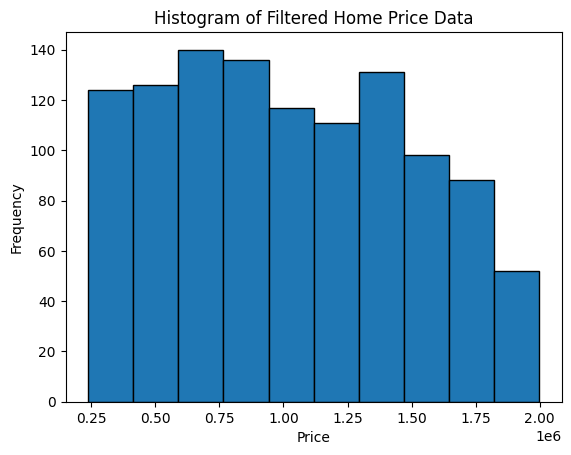

In [20]:
combined_data['price'].plot(kind='hist', bins=10, edgecolor='black', title='Distribution of Sales Prices')
plt.pyplot.xlabel("Price")
plt.pyplot.ylabel("Frequency")
plt.pyplot.title("Histogram of Filtered Home Price Data")
plt.pyplot.show()

In [21]:
X = combined_data[['year_built', 'interior_sqft', 'bedrooms', 'sale_date_ord', 'acres', 'median_price_zip']]
y = combined_data[['price']]

regr = linear_model.LinearRegression()
regr.fit(X.values, y)

pred_sale_date = pd.to_datetime("2025-07-01").toordinal()

# print(pred_sale_date)
input_zip = 22032
mpz = combined_data[combined_data['zip_code'] == input_zip]['median_price_zip']
mpz = mpz.iloc[0]
predicted_price = regr.predict([[2022, 2200, 3, pred_sale_date, 3, mpz]])
formatted_price = predicted_price.astype(float)[0][0]
currency_string = f"${formatted_price:,.2f}"
print(currency_string)

$1,175,787.09


In [22]:
# X = combined_data[['interior_sqft', 'bedrooms', 'baths', 'sale_date_ord', 'acres', 'median_price_zip']]
X = combined_data[['year_built', 'interior_sqft', 'bedrooms', 'baths', 'sale_date_ord', 'acres', 'median_price_zip']]
y = combined_data[['price']]

regr = linear_model.LinearRegression()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=33)
regr.fit(X_train.values, y_train)
y_pred_test = regr.predict(X_test.values)
train_score = regr.score(X_train.values, y_train)
pred_score = regr.score(X_test.values, y_test)
print(train_score)
print(pred_score)
mean_squared_error(y_test, y_pred_test)

0.7048977168238779
0.7166838165107157


58699542661.457054

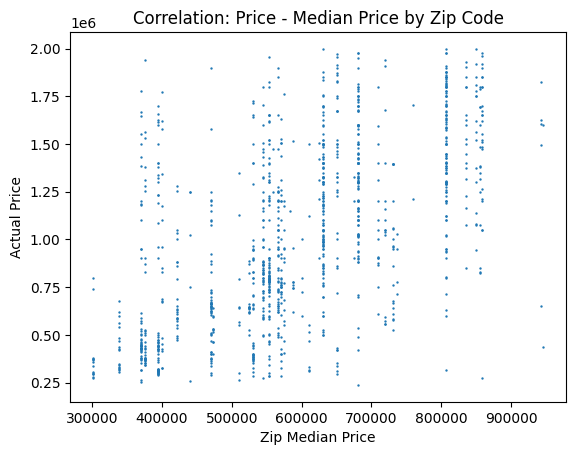

In [23]:
plt.pyplot.scatter(X['median_price_zip'], y, s=0.5)
plt.pyplot.xlabel("Zip Median Price")
plt.pyplot.ylabel("Actual Price")
plt.pyplot.title("Correlation: Price - Median Price by Zip Code")
plt.pyplot.show()

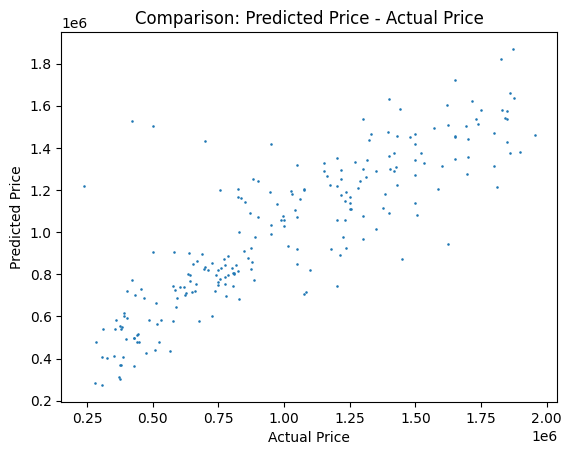

In [24]:
plt.pyplot.scatter(y_test, y_pred_test, s=0.7)
plt.pyplot.xlabel("Actual Price")
plt.pyplot.ylabel("Predicted Price")
plt.pyplot.title("Comparison: Predicted Price - Actual Price")
plt.pyplot.show()

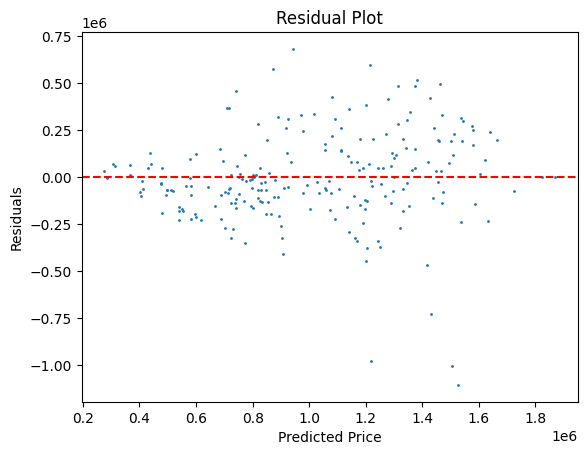

In [25]:
residuals = y_test - y_pred_test
plt.pyplot.scatter(y_pred_test, residuals, s=1)
plt.pyplot.xlabel('Predicted Price')
plt.pyplot.ylabel('Residuals')
plt.pyplot.title('Residual Plot')
plt.pyplot.axhline(y=0, color='r', linestyle='--')
plt.pyplot.show()

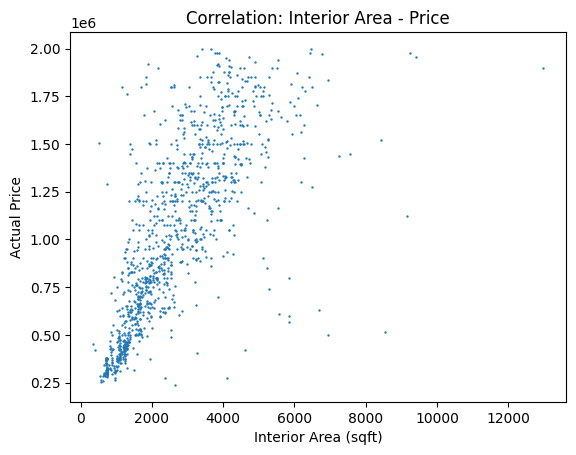

In [26]:
plt.pyplot.scatter(X['interior_sqft'], y, s=0.5)
plt.pyplot.xlabel("Interior Area (sqft)")
plt.pyplot.ylabel("Actual Price")
plt.pyplot.title("Correlation: Interior Area - Price")
plt.pyplot.show()

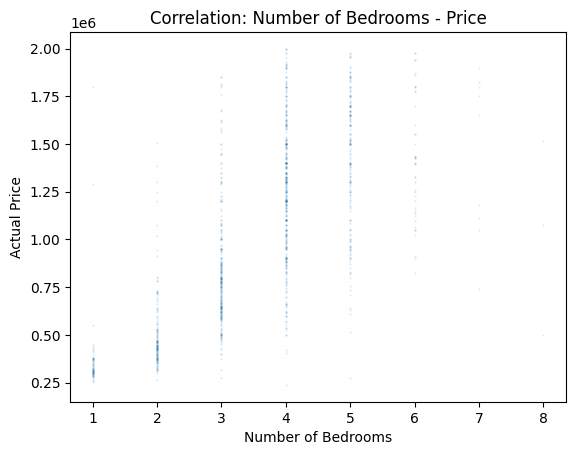

In [27]:
plt.pyplot.scatter(X['bedrooms'], y, s=0.5, alpha=0.1)
plt.pyplot.xlabel("Number of Bedrooms")
plt.pyplot.ylabel("Actual Price")
plt.pyplot.title("Correlation: Number of Bedrooms - Price")
plt.pyplot.show()

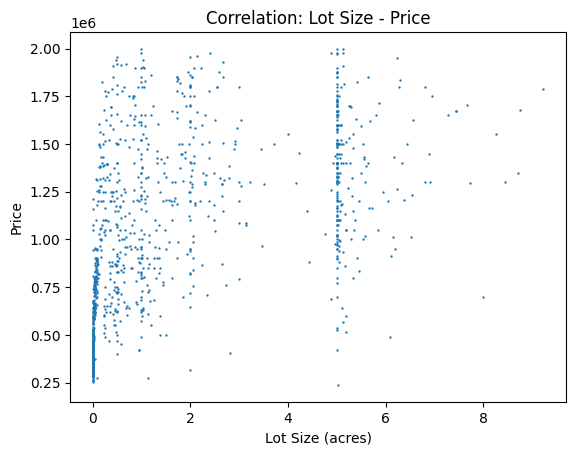

In [28]:
plt.pyplot.scatter(X['acres'], y, s=0.5)
plt.pyplot.xlabel("Lot Size (acres)")
plt.pyplot.ylabel("Price")
plt.pyplot.title("Correlation: Lot Size - Price")
plt.pyplot.show()

In [29]:
with open('home_sales_lr_model.pkl', 'wb') as file:
    pickle.dump(regr, file)

In [30]:
zip_code_list = combined_data['zip_code'].unique()

median_price_by_zip = pd.DataFrame(columns=['zip_code', 'median_price'])
for zc in zip_code_list:
    mp = combined_data[combined_data['zip_code'] == zc]['median_price_zip']
    mp = mp.iloc[0]
    median_price_by_zip.loc[len(median_price_by_zip)] = [int(zc), int(mp)]
median_price_by_zip.sort_values(by='zip_code', inplace=True, ignore_index=True)
print(median_price_by_zip)
median_price_by_zip.to_csv('./median_price_by_zip.csv')

    zip_code  median_price
0      20120        530000
1      20121        510000
2      20124        630000
3      20151        300671
4      20170        570000
5      20171        470000
6      20190        338000
7      20191        675300
8      20194        946269
9      22003        565500
10     22015        569750
11     22027        583500
12     22030        553300
13     22031        375425
14     22032        710000
15     22033        370000
16     22039        680000
17     22041        610000
18     22042        399900
19     22043        625000
20     22044        760000
21     22046        942000
22     22066        806000
23     22079        545000
24     22101        850000
25     22102        857944
26     22124        650000
27     22150        599900
28     22152        472895
29     22153        736000
30     22180        720000
31     22181        395000
32     22182        835000
33     22303        587000
34     22306        525000
35     22307        440000
3

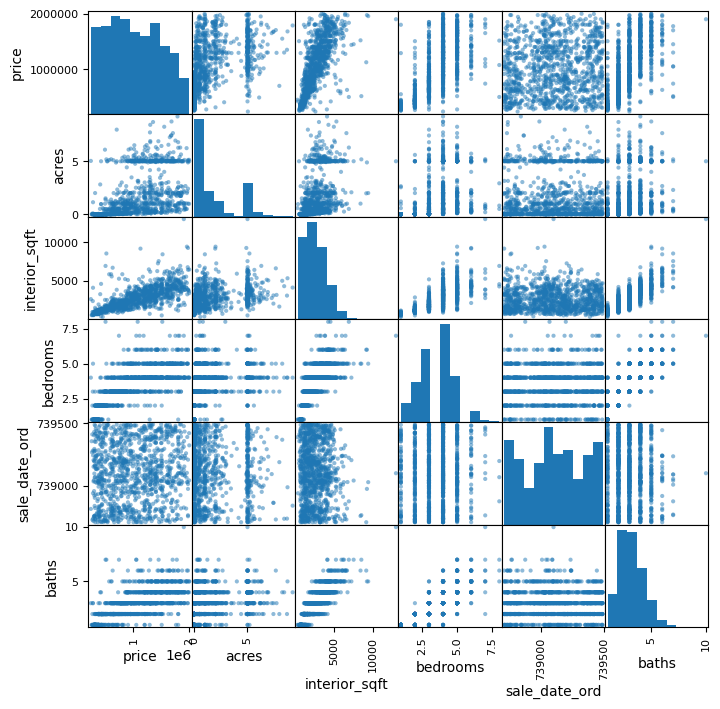

In [31]:
from pandas.plotting import scatter_matrix
scatter_matrix(combined_data[['price', 'acres', 'interior_sqft', 'bedrooms', 'sale_date_ord', 'levels_style', 'baths']], figsize=(8,8))
plt.pyplot.show()